This is a reimplementation of [this notebook](https://github.com/cstckr/residuals_and_droppath/blob/main/residuals_and_droppath.ipynb) in Pytorch Lightning. In short, this notebook is concerned with the identification of cracked walls from images. As "special features" DropPath, residual blocks, and a custom learning rate scheduler are implemented here. 

In contrast to previously linked implementation in Tensorflow in that accuracy was used as a "success criterion", in this notebook we are trying to put this problem into a more realistic "business context". The achieved ~91% accuracy in the Tensorflow implementation sound nice, however we also have to keep in mind that the dataset is somewhat imbalanced and ~80% of all images do not contain cracks. 

A more realistic business context to this dataset might not be to classify the images but to rank them. Then the objective here might be to automatically remove as many non-cracked wall images as possible from the pool while not removing more than a certain percentage of cracked wall images. E.g., it might be known that on average even an average human annotator wrongfully removes 10% of all cracked wall images due to sloppiness. To relieve human annotators, our model threshold is supposed to be set at such a threshold that it will not wrongfully remove more than those 10% of all cracked wall images. And the goal then is for the model to remove a maximum of non-cracked wall images from the pool while staying below this threshold.

The scenario described above translates to evaluating the [partial AUC ROC](https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve) with a maximum false positive rate of 0.1. Therefore, we will log and evaluate this metric in this notebook at all stages.

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.6 MB/s eta 0:00:00


In [2]:
import urllib
import zipfile
import os
import ssl
import copy
import torch
import torch.nn as nn
from torch.nn import (
    Linear, Conv2d, Sequential, ReLU, BatchNorm2d, MaxPool2d, AdaptiveMaxPool2d)
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiplicativeLR
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC
import numpy as np
from PIL import Image
import random
from torchsummary import summary
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import albumentations as A
from pathlib import Path
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
input_shape = (3, 256, 256)
filters = [64, 128, 128, 256, 256, 512] 
kernels = [256, 256]
droppath_prob = 0.03
dropout_prob = 0.4
batch_size = 64

epochs = 130
patience_early_stopping = 30

lr_init = 2e-4
lr_decay = 0.97
lr_max = lr_init * 2
f_reduction = 0.25
f_restart = 1.2
patience = 4
min_loss_improvement = 0.005
no_of_restarts_init = 1
increment_no_of_restarts = 1

max_fpr = 0.1

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context
url = "https://digitalcommons.usu.edu/cgi/viewcontent.cgi?filename=2&article=1047&context=all_datasets&type=additional"
data_dir = "./data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(data_dir)
    
fps_cracked_walls = next(os.walk(data_dir + "/W/CW"))[2]
fps_cracked_walls = [(data_dir + "/W/CW/" + x) for x in fps_cracked_walls]
fps_uncracked_walls = next(os.walk(data_dir + "/W/UW"))[2]
fps_uncracked_walls = [(data_dir + "/W/UW/" + x) for x in fps_uncracked_walls]

fps_walls = fps_cracked_walls + fps_uncracked_walls
random.shuffle(fps_walls)

In [5]:
def split_data(fps, train_ratio, val_ratio):
  test_ratio = 1 - train_ratio - val_ratio
  no_train_samples = int(len(fps) * train_ratio)
  no_test_samples =  int(len(fps) * test_ratio)
  
  fps_train = random.sample(fps, no_train_samples)
  fps_val = [x for x in fps if x not in fps_train]
  fps_test = random.sample(fps_val, no_test_samples)
  fps_val = [x for x in fps_val if x not in fps_test]
  return fps_train, fps_val, fps_test
    
   
class WallDataset(Dataset):
  def __init__(self, fps, augment=False):
    self.fps = fps
    self.augment = augment
  
  def __len__(self):
    return len(self.fps)
  
  def __getitem__(self, idx):
    fp = self.fps[idx]
    img = np.array(Image.open(fp), dtype=np.float32) / 255

    if self.augment:
      transform = A.Compose([
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.3),
          A.Compose([
              A.RandomCrop(
                  width=int(img.shape[1] * random.uniform(0.9, 1)), 
                  height=int(img.shape[0] * random.uniform(0.9, 1))),
                A.Resize(img.shape[0], img.shape[1])], p=0.3),
          A.ColorJitter(p=0.3)])
      transformed = transform(image=img)
      img = transformed["image"]


    img = np.moveaxis(img, 2, 0)
    img = torch.tensor(img).float()
    
    if "CW" in fp:
      y = torch.tensor([0]).float()
    elif "UW" in fp:
      y = torch.tensor([1]).float()
    return img, y


fps_train, fps_val, fps_test = split_data(fps_walls, 0.3, 0.2)
ds_train = WallDataset(fps_train, augment=True)
ds_val = WallDataset(fps_val)
ds_test = WallDataset(fps_test)

loader_train = DataLoader(
    ds_train, batch_size=batch_size, shuffle=True, num_workers=2, 
    pin_memory=True, persistent_workers=True)
loader_val = DataLoader(
    ds_val, batch_size=batch_size, shuffle=False, num_workers=2, 
    pin_memory=True, persistent_workers=True)
loader_test = DataLoader(
    ds_test, batch_size=batch_size, shuffle=False, num_workers=2, 
    pin_memory=True, persistent_workers=True)

DropPath:

In [6]:
class DropPath(nn.Module):
  def __init__(self, droppath_prob):
    super(DropPath, self).__init__()
    self.drop_prob = droppath_prob

  def forward(self, x):
    if self.drop_prob == 0. or not self.training:
        return x
    keep_prob = 1 - self.drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  
    mask = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    mask.floor_() 
    output = x.div(keep_prob) * mask
    return output

Residual block:

In [7]:
class Residual(nn.Module):
  def __init__(self, filters_in, filters_out, droppath_prob):
    super().__init__()
    self.bn1 = BatchNorm2d(filters_in)
    self.bn2 = BatchNorm2d(filters_out//2)
    self.bn3 = BatchNorm2d(filters_out//2)
    self.activation = ReLU()
    self.conv1 = Conv2d(
        in_channels=filters_in, out_channels=filters_out, 
        kernel_size=1, stride=1, padding="same")
    self.conv2 = Conv2d(
        in_channels=filters_in, out_channels=filters_out//2, 
        kernel_size=1, stride=1, padding="same")
    self.conv3 = Conv2d(
        in_channels=filters_out//2, out_channels=filters_out//2, 
        kernel_size=3, stride=1, padding="same")
    self.conv4 = Conv2d(
        in_channels=filters_out//2, out_channels=filters_out, 
        kernel_size=1, stride=1, padding="same")
    self.droppath = DropPath(droppath_prob)

  def forward(self, x):
    x = self.bn1(x)
    x = self.activation(x)
    x_skip = self.conv1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.activation(x)

    x = self.conv4(x)
    x = self.droppath(x)
    x = x_skip + x
    return x

In [8]:
class Encoder(nn.Module):
  def __init__(self, img_shape, filter_sizes, droppath_prob):
    super().__init__()
    self.filter_sizes = copy.deepcopy(filter_sizes)
    self.filter_sizes.insert(0, img_shape[0])
    modules = []
    modules.append(Conv2d(
        in_channels=self.filter_sizes[0], out_channels=self.filter_sizes[1], 
        kernel_size=5, stride=1, padding="same"))
    modules.append(ReLU())
    modules.append(MaxPool2d((2, 2)))

    for idx in range(0, len(self.filter_sizes) - 2):
      modules.append(Residual(
          self.filter_sizes[idx+1], self.filter_sizes[idx+2], droppath_prob))
      if (idx != len(self.filter_sizes) - 3) and ((idx % 2) != 0):
        modules.append(MaxPool2d((2, 2)))
    self.encoder = Sequential(*modules)

  def forward(self, x):
    return self.encoder(x)

# temp = Encoder(input_shape, [32, 64, 128, 256], 0.03)
# print(summary(temp.to(device), input_shape))

In [9]:
class FFN(nn.Module):
  def __init__(self, kernel_network):
    super().__init__()
    modules = []
    for i in range(len(kernel_network) - 1):
      modules.append(Linear(kernel_network[i], kernel_network[i+1]))
      if i != len(kernel_network) - 2:
        modules.append(ReLU())
    self.ffn = Sequential(*modules)

  def forward(self, x):
    return self.ffn(x)

Our custom learning rate scheduler:

In [10]:
class MultiplicativeDecayWithReduceOrRestartOnPlateau:
  def __init__(self, optimizer, lr_init, lr_decay, lr_max, f_reduction, 
               f_restart, patience, min_loss_improvement, 
               no_of_restarts_init, increment_no_of_restarts):
    self.optimizer = optimizer
    self.lr_init = lr_init
    self.lr_decay = lr_decay
    self.lr_max = lr_max
    self.f_reduction = f_reduction
    self.f_restart = f_restart
    self.patience = patience
    self.min_loss_improvement = min_loss_improvement
    self.no_of_restarts_init = no_of_restarts_init
    self.increment_no_of_restarts = increment_no_of_restarts
    
    self.loss_best = np.Inf
    self.plateau_epochs = 0
    self.reductions_counter = 0
    self.just_restarted = False
    
    self.set_par("initial_lr", self.lr_init)
    self.set_par("lr", self.lr_init)
  
  def get_par(self, name):
    for group in self.optimizer.param_groups: par = group[name]
    return par
    
  def set_par(self, name, value):
    for group in self.optimizer.param_groups: group[name] = value
        
  def on_loss_improvement(self, loss_cur):
    self.loss_best = loss_cur
    self.plateau_epochs = 0
            
  def on_loss_deterioration(self):
    self.plateau_epochs += 1
        
  def multiplicative_decay_lr(self, lr):
    return lr * self.lr_decay
    
  def on_plateau(self, lr):
    if self.reductions_counter >= self.no_of_restarts_init:
      lr_new = self.restart_lr()
    else:
      lr_new = self.steep_reduce_lr(lr)
    return lr_new
    
  def steep_reduce_lr(self, lr):
    lr_new = lr * self.f_reduction
    self.plateau_epochs = 0
    self.reductions_counter += 1
    return lr_new
    
  def restart_lr(self):
    self.lr_init *= self.f_restart
    lr_new = self.lr_init
    if lr_new > self.lr_max:
      lr_new = self.lr_max
    self.plateau_epochs = 0
    self.reductions_counter = 0
    self.no_of_restarts_init += self.increment_no_of_restarts
    self.just_restarted = True
    return lr_new
        
  def step(self, metrics):
    lr_cur = self.get_par("lr")
    loss_cur = float(metrics)
        
    if 1 - (loss_cur / self.loss_best) > self.min_loss_improvement:
      self.on_loss_improvement(loss_cur)
    else:
      self.on_loss_deterioration() 
    lr_new = self.multiplicative_decay_lr(lr_cur)
        
    if self.just_restarted:
      self.loss_best = loss_cur
      self.just_restarted = False
            
    if self.plateau_epochs >= self.patience:
      lr_new = self.on_plateau(lr_cur)
        
    self.set_par("lr", lr_new)

Our model in Pytorch Lightning:

In [11]:
cb1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb2 = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience_early_stopping)
cb3 = LearningRateMonitor(logging_interval="epoch")

logger = CSVLogger(save_dir="logs/", name="cnn001", flush_logs_every_n_steps=1)


class CNN001(pl.LightningModule):
  def __init__(self, img_shape, filter_sizes, kernel_network, droppath_prob, 
               dropout_prob):
    super().__init__()
    self.automatic_optimization = False
    self.encoder = Encoder(img_shape, filter_sizes, droppath_prob)
    self.kernel_network = copy.deepcopy(kernel_network)
    
    self.kernel_network.append(1)  # number of classes
    self.kernel_network.insert(0, filter_sizes[-1])
    self.ffn = FFN(self.kernel_network)
    self.dropout = nn.Dropout(p=dropout_prob)
    self.sigmoid = nn.Sigmoid() 

    # Metrics
    self.train_accuracy = BinaryAccuracy(threshold=0.5)
    self.val_accuracy = BinaryAccuracy(threshold=0.5)
    self.train_auc_roc = BinaryAUROC()
    self.val_auc_roc = BinaryAUROC()
    self.train_pauc_roc = BinaryAUROC(max_fpr)
    self.val_pauc_roc = BinaryAUROC(max_fpr)

  def forward(self, x):
    x = self.encoder(x)
    x = F.max_pool2d(x, kernel_size=x.size()[2])
    x = x.reshape(x.size(0), -1)
    x = self.dropout(x)
    x = self.ffn(x)
    x = self.sigmoid(x)
    return x

  def training_step(self, batch, batch_idx):
    opt = self.optimizers()
    opt.zero_grad()
    x, y = batch[0], batch[1]
    y_pred = self.forward(x)
    loss = F.binary_cross_entropy(y_pred, y)
    
    # For logging loss & metrics
    self.log("train_loss", loss, on_step=False, on_epoch=True, 
             prog_bar=True)
    self.train_accuracy.update(y_pred, y)
    self.train_auc_roc.update(y_pred, y)
    self.train_pauc_roc.update(y_pred, y)

    self.manual_backward(loss)
    opt.step()
    return loss

  def on_train_epoch_end(self):
    # Just logging and reseting metrics
    self.log("train_accuracy", self.train_accuracy.compute(), prog_bar=True)
    self.train_accuracy.reset()
    self.log("train_auc_roc", self.train_auc_roc.compute(), prog_bar=True)
    self.train_auc_roc.reset()
    self.log("train_pauc_roc", self.train_pauc_roc.compute(), prog_bar=True)
    self.train_pauc_roc.reset()

  def validation_step(self, batch, batch_idx):
    x, y = batch[0], batch[1]
    y_pred = self.forward(x)
    loss = F.binary_cross_entropy(y_pred, y)
    
    # For logging loss & metrics
    self.log("val_loss", loss, on_step=False, on_epoch=True, 
             prog_bar=True)
    self.val_accuracy.update(y_pred, y)
    self.val_auc_roc.update(y_pred, y)
    self.val_pauc_roc.update(y_pred, y)

    # Take care of non-default scheduler
    if batch_idx == 0:
      self.cur_val_loss = []    
    self.cur_val_loss.append(loss)
    
    return loss

  def on_validation_epoch_end(self):
    # Take care of non-default scheduler
    self.cur_val_loss = torch.stack(self.cur_val_loss).mean()
    self.scheduler.step(self.cur_val_loss)

    # Log metrics
    self.log("val_accuracy", self.val_accuracy.compute(), prog_bar=True)
    self.val_accuracy.reset()
    self.log("val_auc_roc", self.val_auc_roc.compute(), prog_bar=True)
    self.val_auc_roc.reset()
    self.log("val_pauc_roc", self.val_pauc_roc.compute(), prog_bar=True)
    self.val_pauc_roc.reset()

  def predict_step(self, batch, batch_idx):
    if isinstance(batch, list): # Dataloaders that return both X and y
      return self(batch[0]), batch[1]
    else: # Dataloaders that return only y
      return self(batch)
  
  def configure_optimizers(self):
    opt = torch.optim.Adam(self.parameters(), lr=lr_init)
    self.scheduler = MultiplicativeDecayWithReduceOrRestartOnPlateau(
        optimizer=opt, lr_init=lr_init, lr_decay=lr_decay, 
        lr_max=lr_max, f_reduction=f_reduction, f_restart=f_restart, 
        patience=patience, min_loss_improvement=min_loss_improvement, 
        no_of_restarts_init=no_of_restarts_init, 
        increment_no_of_restarts=increment_no_of_restarts)
    return opt


cnn001 = CNN001(
    img_shape=input_shape, filter_sizes=filters, kernel_network=kernels, 
    droppath_prob=droppath_prob, dropout_prob=dropout_prob)

# print(summary(cnn001.to(device), (3, 256, 256)))

Let's train:

In [12]:
trainer1 = pl.Trainer(
    max_epochs=epochs, check_val_every_n_epoch=1, profiler="simple",
    callbacks=[cb1, cb2, cb3], logger=logger,
    accelerator="gpu", devices=1,
    # enable_progress_bar=False
    )

trainer1.fit(
    model=cnn001, train_dataloaders=loader_train, val_dataloaders=loader_val)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
print(trainer1.profiler.summary()[:4500])

FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -       

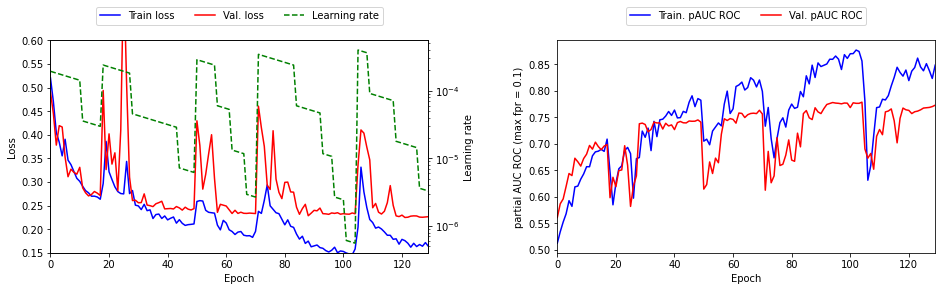

In [14]:
logs = pd.read_csv(Path(trainer1.logger.log_dir + "/metrics.csv"))
epochs = logs.dropna(subset=["train_loss"])["epoch"]

fig1, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 5))
l1 = ax1.plot(
    epochs, logs["train_loss"].dropna(), color="b", label="Train loss")
l2 = ax1.plot(
    epochs, logs["val_loss"].dropna(), color="r", label="Val. loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_xlim(0, len(epochs)-1)
ax1.set_ylim(0.15, 0.6)
ax2 = ax1.twinx() 
l3 = ax2.plot(
    epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed", 
    label="Learning rate")
ax2.set_ylabel("Learning rate")
ax2.set_yscale("log")
ax1.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
           bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)

ax3.plot(
    epochs, logs["train_pauc_roc"].dropna(), color="b", label="Train. pAUC ROC")
ax3.plot(
    epochs, logs["val_pauc_roc"].dropna(), color="r", label="Val. pAUC ROC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("partial AUC ROC (max fpr = 0.1)")
ax3.set_xlim(0, len(epochs)-1)
ax3.legend(loc="lower center", bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=2)
plt.tight_layout(pad=4)
plt.show()

On the holdout test data, our model achieves an accuracy comparable to the Tensorflow implementation of this model:

In [15]:
checkpoint_file = trainer1.checkpoint_callback.best_model_path
print(checkpoint_file)
cnn001.load_from_checkpoint(
    checkpoint_file, img_shape=input_shape, filter_sizes=filters, 
    kernel_network=kernels, droppath_prob=droppath_prob, 
    dropout_prob=dropout_prob)
cnn001.eval()

trainer2 = pl.Trainer(accelerator="gpu", devices=1,)
y_test_out = trainer2.predict(model=cnn001, dataloaders=loader_val)
y_test_pred = torch.cat([x[0] for x in y_test_out])
y_test = torch.cat([x[1] for x in y_test_out])

metric = BinaryAccuracy(threshold=0.5)
accuracy = metric(y_test_pred, y_test)
print(accuracy.numpy())

logs/cnn001/version_0/checkpoints/epoch=121-step=10492.ckpt


Predicting: 0it [00:00, ?it/s]

0.92174155


But more importantly, let's evaluate the partial AUC ROC at a maximum false positive rate of 0.1 on the holdout test data:

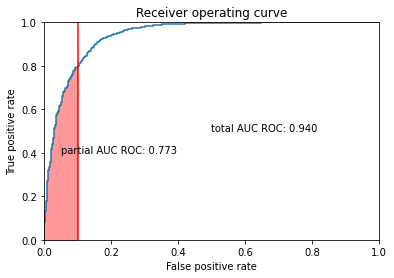

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1)
pauc_roc = roc_auc_score(y_test, y_test_pred, max_fpr=0.1)
auc_roc = roc_auc_score(y_test, y_test_pred)


fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.axvline(x=max_fpr, color="r")
ax.fill_between(
    fpr[fpr < max_fpr], tpr[fpr < max_fpr], step="pre", alpha=0.4, color="r")
ax.annotate(text=f"partial AUC ROC: {pauc_roc:.3f}", 
            xy=(max_fpr * 0.5, tpr[np.argmax(fpr > max_fpr)] * 0.5))
ax.annotate(text=f"total AUC ROC: {auc_roc:.3f}", 
            xy=(0.5, 0.5))
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.title("Receiver operating curve")
plt.show()